In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ddpg import Actor, Critic
from naf.priority_buffer import PriorityBuffer
from environment import Environment, WIN, LOSE, NEUTRAL

Using Theano backend.


In [2]:
MAX_DIST = 0.01
env = Environment(MAX_DIST, 'reaching-fixed-goal')

In [3]:
actor = Actor(env.get_state().shape[1], 2, output_scaling=MAX_DIST)
actor_target = Actor(env.get_state().shape[1], 2, output_scaling=MAX_DIST)
actor_target.clone_params(actor)

In [4]:
critic = Critic(env.get_state().shape[1], 2)
critic_target = Critic(env.get_state().shape[1], 2)
critic_target.clone_params(critic)

In [7]:
def return_average(env, actor, gamma=0.98):
    rewards = []
    for trial in range(32):
        np.random.seed(trial)
        env.reset()
        n_steps = 256
        return_ = 0.0
        for i in range(n_steps):
            mu = actor.predict(env.get_state())
            _, r, _ = env.interact(*mu.flatten())
            return_ += gamma ** i * r
        rewards.append(return_)
    return np.mean(rewards), np.std(rewards)

return_average(env, actor)

(-38.085411068171823, 11.670935171526958)

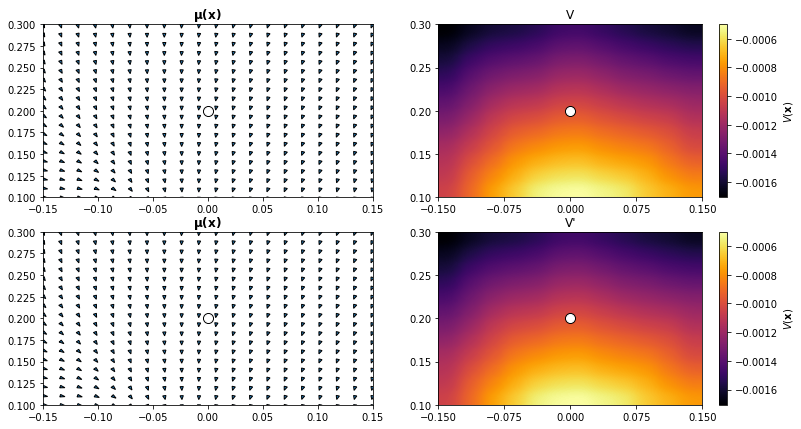

In [34]:
def plot_q(nn, eef_x, eef_y, cube_x, cube_y, goal_x, goal_y):
    xs = np.linspace(-0.01, 0.01, 12)
    ys = np.linspace(-0.01, 0.01, 12)
    xss, yss = np.meshgrid(xs, ys)
    zss = np.zeros(xss.shape)
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            zss[len(ys) - j - 1, i] = nn.predict(
                np.array([[eef_x, eef_y, goal_x, goal_y]]),
                np.array([[x, y]])
            )[0, 0]
    plt.imshow(zss, cmap='inferno', interpolation='gaussian', aspect='auto',
               extent=[-0.01, 0.01, -0.01, 0.01])
    plt.plot(0.0, 0.0, 'ko', markersize=10)
    plt.plot(0.0, 0.0, 'w+', markersize=10)
    plt.xticks(np.linspace(-0.01, 0.01, 5))
    plt.yticks(np.linspace(0.01, -0.01, 5))
    plt.colorbar().set_label('$Q(\mathbf{x, u})$')


def plot_pi(nn, env):
    for x in np.linspace(env.min_x, env.max_x, 20):
        for y in np.linspace(env.min_y, env.max_y, 20):
            env.eef_x = x
            env.eef_y = y
            dx, dy = nn.predict(env.get_state())[0, :]
            plt.arrow(x, y, dx, dy)
    if env.mode.startswith('pushing'):
        plt.plot(env.circle.x, env.circle.y, 'ko', markersize=10)
        plt.plot(env.circle.x, env.circle.y, 'ro', markersize=8)
    plt.plot(env.goal_x, env.goal_y, 'ko', markersize=10)
    plt.plot(env.goal_x, env.goal_y, 'wo', markersize=8)
    plt.title('$\mathbf{\mu(x)}$')
    plt.xlim(env.min_x, env.max_x)
    plt.ylim(env.min_y, env.max_y)
    
def plot_v(actor, critic, env):
    xs = np.linspace(env.min_x, env.max_x, 12)
    ys = np.linspace(env.min_y, env.max_y, 12)
    xss, yss = np.meshgrid(xs, ys)
    zss = np.zeros(xss.shape)
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            env.eef_x = x
            env.eef_y = y
            zss[len(ys) - j - 1, i] = critic.predict(
                env.get_state(),
                actor.predict(
                    env.get_state()
                )
            )[0, 0]
    plt.imshow(zss, cmap='inferno', interpolation='gaussian', aspect='auto',
               extent=[env.min_x, env.max_x, env.min_y, env.max_y])
    plt.plot(env.goal_x, env.goal_y, 'ko', markersize=10)
    plt.plot(env.goal_x, env.goal_y, 'wo', markersize=8)
    if env.mode.startswith('pushing'):
        plt.plot(env.circle.x, env.circle.y, 'ko', markersize=10)
        plt.plot(env.circle.x, env.circle.y, 'ro', markersize=8)
    plt.xticks(np.linspace(env.min_x, env.max_x, 5))
    plt.yticks(np.linspace(env.min_y, env.max_y, 5))
    plt.colorbar().set_label('$V(\mathbf{x})$')
    
#
##print('Targets')
##plt.subplot(121)
##plot_pi(actor_target, e.circle.x, e.circle.y, e.goal_x, e.goal_y, eef=(e.eef_x, e.eef_y))
##plt.subplot(122)
##plot_q(critic_target, e.eef_x, e.eef_y, e.circle.x, e.circle.y, e.goal_x, e.goal_y)
##plt.show()
#
def plot_shebang(actor, critic, actor_target, critic_target, env):
    env.reset()
    plt.figure(figsize=(13, 7))
    plt.subplot(221)
    plot_pi(actor, env)
    plt.subplot(222)
    plt.title('V')
    plot_v(actor, critic, env)
    plt.subplot(223)
    plot_pi(actor_target, env)
    plt.subplot(224)
    plt.title('V\'')
    plot_v(actor_target, critic_target, env)
    plt.show()
    
plot_shebang(actor, critic, actor_target, critic_target, env)

In [74]:
def sample_transition(env, priority_buffer):
    x1 = env.get_state()
    mu = MAX_DIST * np.tanh(75 * MAX_DIST * np.random.randn(2))
    end_state, reward, x2 = env.interact(*mu)
    priority_buffer.add({
        'x1': x1[:, 0],
        'x2': x2[:, 0],
        'reward': reward,
        'mu': mu,
        'end_state': end_state
    }).set_value(10.0)
    if end_state in [WIN, LOSE]:
        env.reset()

In [75]:
priority_buffer = PriorityBuffer(2 ** 20)

for i in range(65536):
    env.reset()
    sample_transition(env, priority_buffer)

In [119]:
def sample_batch(X, Y, U, R, S, critic, actor_target, critic_target, priority_buffer, gamma=0.99):
    nodes = []
    for i in range(X.shape[0]):
        sample = priority_buffer.sample()
        nodes.append(sample)
        X[i, :] = sample.data['x1']
        U[i, :] = sample.data['mu']
        R[i, :] = sample.data['reward']
        S[i, :] = sample.data['end_state']
    Y[:, :] = R + gamma * critic_target.predict(X, actor_target.predict(X))
    [node.set_value(abs(e[0]) + 1e-6) for node, e in zip(nodes, critic.predict(X, U) - Y)]
    Y[S == WIN] = R[S == WIN]

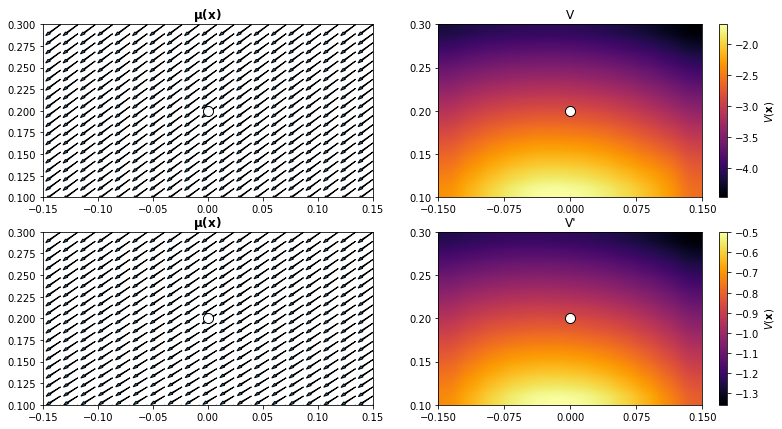

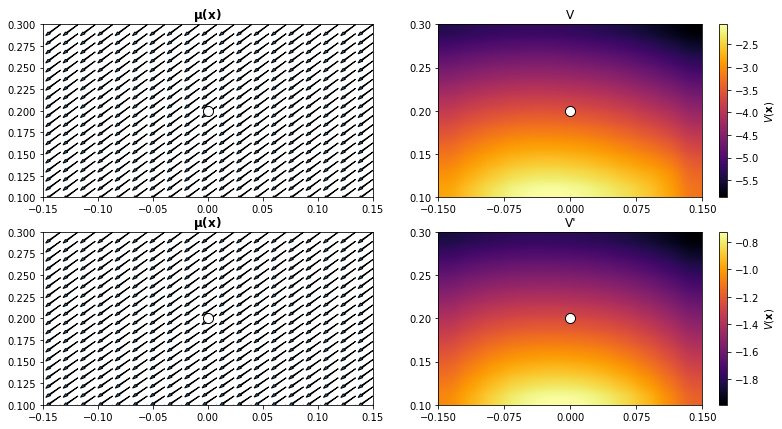

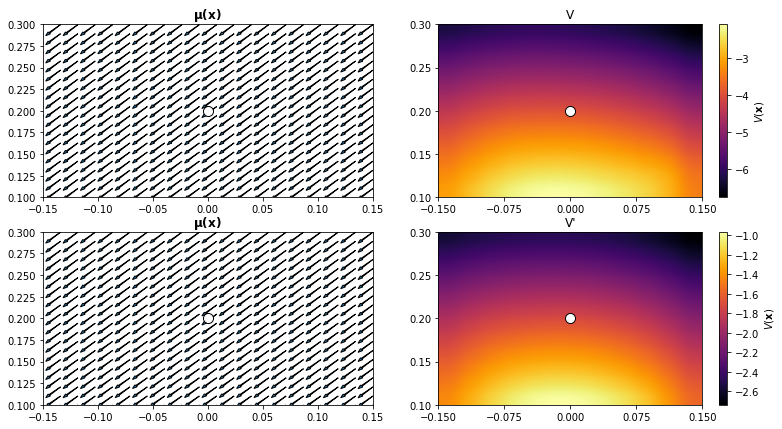

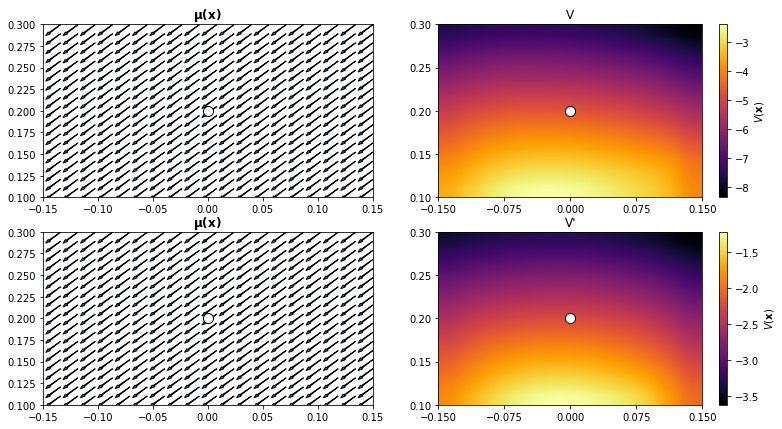

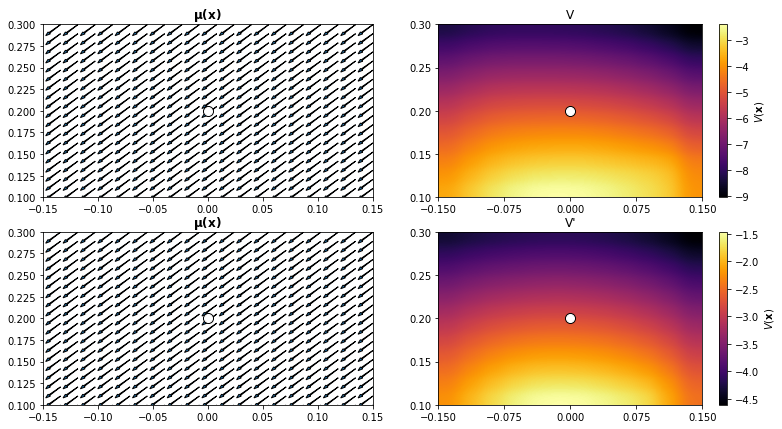

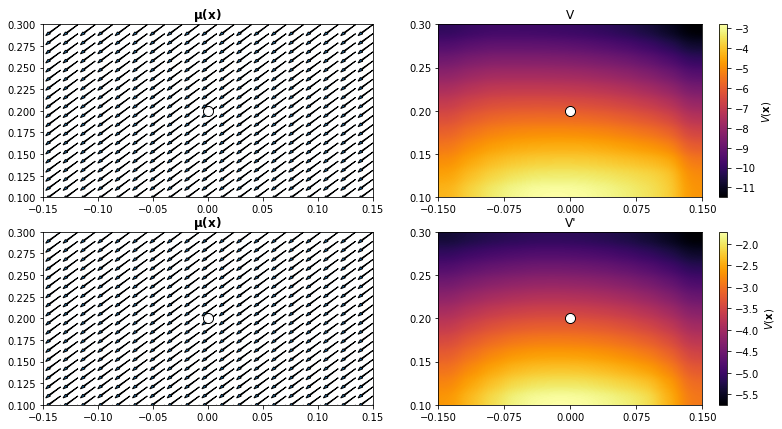

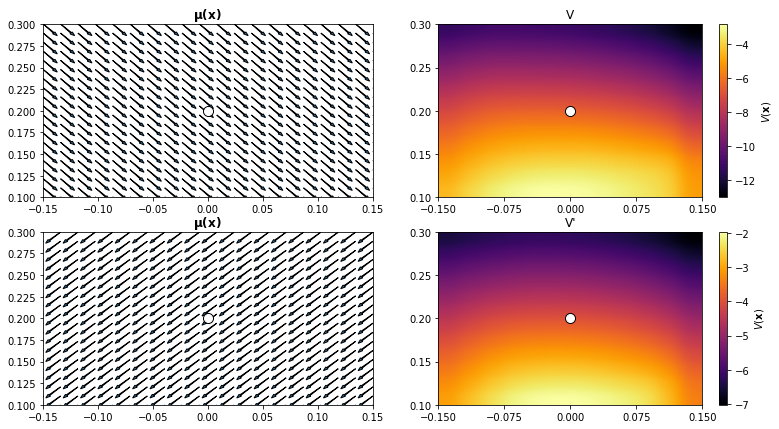

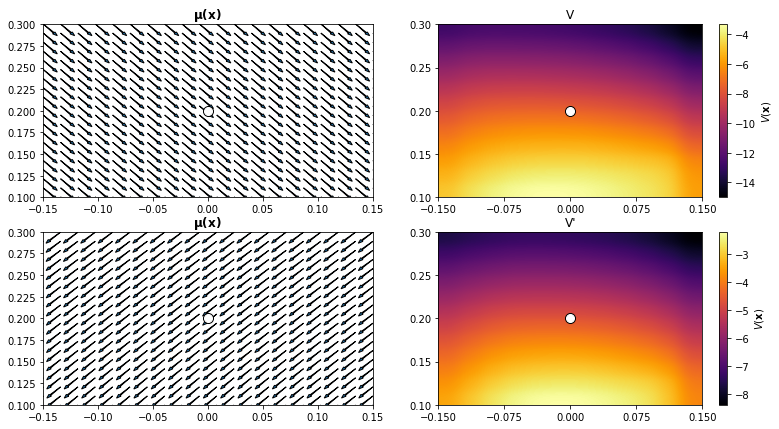

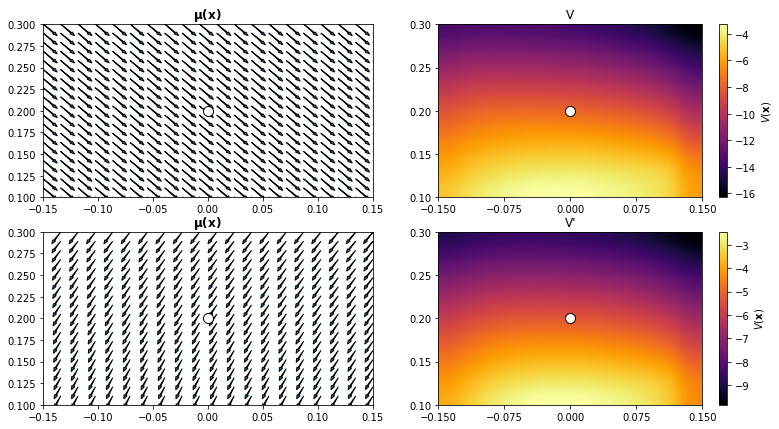

In [ ]:
n_iterations = 10000
batch_size = 64

X = np.zeros((batch_size, env.get_state().shape[1]))
U = np.zeros((batch_size, 2))
Y = np.zeros((batch_size, 1))
R = np.zeros((batch_size, 1))
S = np.zeros((batch_size, 1))

for iteration in range(n_iterations):
    sample_transition(env, priority_buffer)
    sample_batch(X, Y, U, R, S, critic, actor_target, critic_target, priority_buffer)
    critic.fit(X, U, Y)
    actor.fit(X, U, critic)
    critic_target.soft_update(critic)
    actor_target.soft_update(actor)
    if iteration % 256 == 0:
        plot_shebang(actor, critic, actor_target, critic_target, env)